# TODO: Title

This notebook lists all the steps that you need to complete the complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

  Using cached smdebug-1.0.12-py2.py3-none-any.whl (270 kB)
  Using cached pyinstrument-3.4.2-py2.py3-none-any.whl (83 kB)
  Using cached pyinstrument_cext-0.2.4-cp37-cp37m-manylinux2010_x86_64.whl (20 kB)


In [3]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
import sagemaker
import boto3
import os

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [4]:
#TODO: Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-10-11 08:03:17--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.112.136
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.112.136|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip’

dogImages.zip       100%[===================>]   1.05G  40.5MB/s    in 35s     

2022-10-11 08:03:55 (30.9 MB/s) - ‘dogImages.zip’ saved [1132023110/1132023110]

Archive:  dogImages.zip
   creating: dogImages/
   creating: dogImages/test/
   creating: dogImages/train/
   creating: dogImages/valid/
   creating: dogImages/test/001.Affenpinscher/
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00023.jpg  
  inflating: dogImages/test/001.Affenpinscher/Affenpinscher_00036.jpg  
  inflating: dogImages/test/001.

In [5]:

bucket = 'project-3-image-classifier'
prefix = 'dog-data-images'
data = sagemaker.Session().upload_data(path='dogImages/', bucket=bucket, key_prefix=prefix)

In [6]:
print("input spec (in this case, just an S3 path): {}".format(data))

input spec (in this case, just an S3 path): s3://project-3-image-classifier/dog-data-images


## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

The hyperparameters I choosed is:
1-Learning rate
Learning rate controls how quickly or slowly a neural network model learns a problem and controls the amount of apportioned error that the weights of the model are updated with each time they are updated. So when it comes to find the best lr will directly affects the preformance of the model.
2-Batch size
The number of training examples in one forward/backward pass. trying to set range between 32 and 256 to make sure the batch size is not too low or too large. trying to make balance between the training process speed and he model performance.

In [4]:
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

In [5]:
#TODO: Declare your HP ranges, metrics etc.
hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch-size": CategoricalParameter([32, 64, 128, 256]),
}

objective_metric_name = "average test loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

In [6]:
#TODO: Create estimators for your HPs

estimator = PyTorch(
    entry_point="hpo.py",
    role=sagemaker.get_execution_role(),
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.g4dn.xlarge"
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [11]:
#after visiting knowledge Q. 805968
output = "s3://{}/{}/".format(bucket, "output")
model_dir = "s3://{}/{}/".format(bucket, "model")
os.environ["DEFAULT_S3_BUCKET"] = bucket
os.environ['SM_CHANNEL_TRAIN']= data 
os.environ['SM_OUTPUT_DATA_DIR']= output
os.environ['SM_MODEL_DIR']= model_dir

In [ ]:
# TODO: Fit your HP Tuner
tuner.fit({'train': data}) # TODO: Remember to include your data channels

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


...........................................................................................................................................................................................................................................................................................!


In [40]:
# TODO: Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()



2022-10-11 11:11:31 Starting - Found matching resource for reuse
2022-10-11 11:11:31 Downloading - Downloading input data
2022-10-11 11:11:31 Training - Training image download completed. Training in progress.
2022-10-11 11:11:31 Uploading - Uploading generated training model
2022-10-11 11:11:31 Completed - Resource retained for reuse


In [41]:
#Get the hyperparameters of the best trained model
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"64"',
 'lr': '0.006388093081081666',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-10-11-10-41-40-448"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-231257662352/pytorch-training-2022-10-11-10-41-40-448/source/sourcedir.tar.gz"'}

P.S> after the training jop was done I closed the notebook. as the rubric requiers that make code gets the best estimator hyperparameters. I can't do that now because best_estimator now not defind , So I made the code anyway but assiend the dict to variable = best_estimator_hyperparameters.(to make the code and meet the rubric.
The code will be the same if i used it on the function , just replace best_estimator_hyperparameters with best_estimator.hyperparameters().

Unfortunatly I can't run the tuner code once again because the cost issues. but the idea is the same. I hope that can be acceptable.
Thanks for understanding.

In [12]:
best_estimator = {'_tuning_objective_metric': '"average test loss"',
 'batch-size': '"64"',
 'lr': '0.006388093081081666',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2022-10-11-10-41-40-448"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-231257662352/pytorch-training-2022-10-11-10-41-40-448/source/sourcedir.tar.gz"'}

In [13]:
best_estimator_hyperparameters={'batch-size': (best_estimator['batch-size'].replace('"', "")),
                      'lr': best_estimator['lr']}
print (best_estimator_hyperparameters)

{'batch-size': '64', 'lr': '0.006388093081081666'}


I will pass the data variable again because the same problem, shutdown the kernel (no need to upload the data once again to s3)

In [14]:
data ="s3://project-3-image-classifier/dog-data-images"

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [15]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import ProfilerConfig, FrameworkProfile, DebuggerHookConfig, CollectionConfig
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)


# after visiting Udacity knowledge referring to Q. NO.777884
collection_configs = [CollectionConfig(name="CrossEntopyLoss_output_0", 
                  parameters={
               "include_regex": "CrossEntropyLoss_output_0",        
               "train_save_interval": "10", "eval.save_interval": "1"
                             }
                  )
]

debugger_config = DebuggerHookConfig(collection_configs=collection_configs)

In [16]:
# TODO: Create and fit an estimator
estimator =  PyTorch(
                    entry_point = 'train_model.py',
                    role = sagemaker.get_execution_role(),
                    instance_count = 1,
                    instance_type = "ml.g4dn.xlarge",
                    hyperparameters = best_estimator_hyperparameters,
                    framework_version = '1.8',
                    py_version='py36',
                    profiler_config = profiler_config,
                    debugger_hook_config= debugger_config,
                    rules = rules)

In [17]:
estimator.fit({'train': data}, wait=True)

2022-10-11 20:44:44 Starting - Starting the training job...
2022-10-11 20:45:10 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-10-11 20:46:38 Downloading - Downloading input data............
2022-10-11 20:48:39 Training - Downloading the training image..................
2022-10-11 20:51:40 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-10-11 20:51:35,930 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-10-11 20:51:35,960 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-10-11 20:51:35,967 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-10-11 20:51:36,549 sagemaker-training-tool

In [18]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

In [19]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2022-10-11 21:21:42.525 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-10-11 21:21:42.539 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-231257662352/pytorch-training-2022-10-11-20-44-43-882/debug-output


In [20]:
trial.tensor_names()

[2022-10-11 21:21:46.404 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-10-11 21:21:47.431 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:18 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer4.0.relu_input_0',
 'layer4.0.relu_input_1',
 'layer4.1.relu_input_0',
 'layer4.1.relu_input_1',
 'relu_input_0']

In [21]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [22]:
# TODO: Plot a debugging output.
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


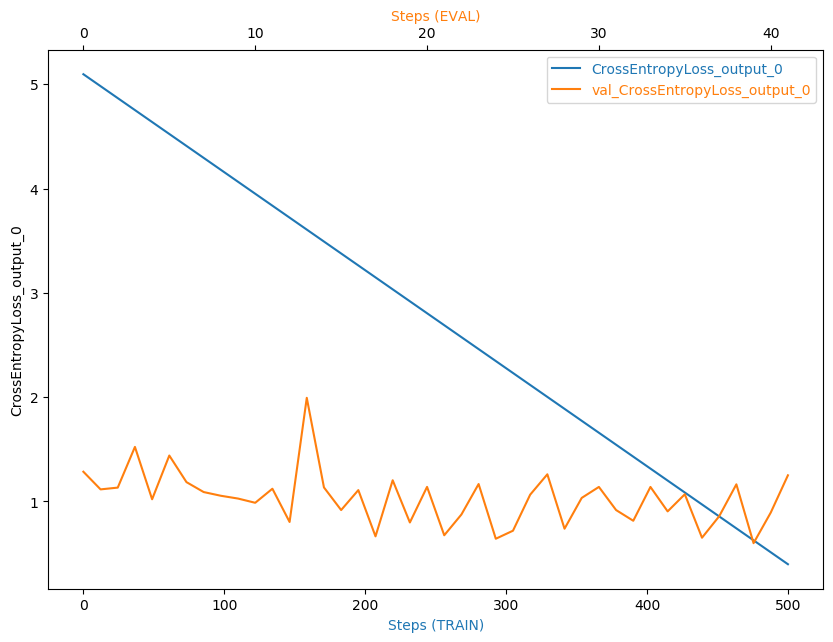

In [23]:
plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  

I think its good to seethe blue line of getting less with more training.

**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

I think the report will give us more details if there a problem , but i think for know epoch mus be incresed.

In [24]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"

In [25]:
! aws s3 ls {rule_output_path} --recursive

2022-10-11 21:02:46     402154 pytorch-training-2022-10-11-20-44-43-882/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-10-11 21:02:45     254514 pytorch-training-2022-10-11-20-44-43-882/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-10-11 21:02:40        192 pytorch-training-2022-10-11-20-44-43-882/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-10-11 21:02:40      39505 pytorch-training-2022-10-11-20-44-43-882/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-10-11 21:02:40       2003 pytorch-training-2022-10-11-20-44-43-882/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-10-11 21:02:40        130 pytorch-training-2022-10-11-20-44-43-882/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-10-11 21:02:40       5585 pytorch-training-2022-10-11-20-44-43-882/rule-output/ProfilerReport/profiler-output/profiler-re

In [26]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-231257662352/pytorch-training-2022-10-11-20-44-43-882/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-231257662352/pytorch-training-2022-10-11-20-44-43-882/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb to ProfilerReport/profiler-output/profiler-report.ipynb
download: s3://sagemaker-us-east-1-231257662352/pytorch-training-2022-10-11-20-44-43-882/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-231257662352/pytorch-training-2022-10-11-20-44-43-882/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://sagemaker-us-east-1-231257662352/pytorch-training

In [27]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]


In [108]:
# TODO: Display the profiler output

import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [ ]:
deployment = img_classifier_model.deploy(
    
    initial_instance_count=1, 
    instance_type="ml.m5.xlarge",                                  
    data_capture_config=data_capture_config
    )

endpoint = deployment.endpoint_name
print(endpoint)

## Model Deploying

In [31]:
#Udacity knowledge Q . No 799166
#Udacity knowledge Q . No 764885
#https://sagemaker.readthedocs.io/en/stable/frameworks/pytorch/using_pytorch.html#load-a-model
#lesson 5 (Operationalizing Machine Learning on SageMaker)
# TODO: Deploy your model to an endpoint

from sagemaker.pytorch.model import PyTorchModel

pytorch_model = PyTorchModel(framework_version=estimator.framework_version,
                             py_version=estimator.py_version,
                             model_data=estimator.model_data, 
                             role=sagemaker.get_execution_role(), 
                             entry_point='infernce2.py')
predictor = pytorch_model.deploy(initial_instance_count=1,
                                 instance_type='ml.m5.xlarge')

-----!

In [99]:
from sagemaker.serializers import IdentitySerializer
from sagemaker.predictor import Predictor
import numpy as np

from PIL import Image
import io


predictor.serializer = IdentitySerializer("image/jpeg")

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )
        
with open("ProfilerReport/test_image.jpg", "rb") as f:
    img_bytes = f.read()

    
responce = predictor.predict(img_bytes)

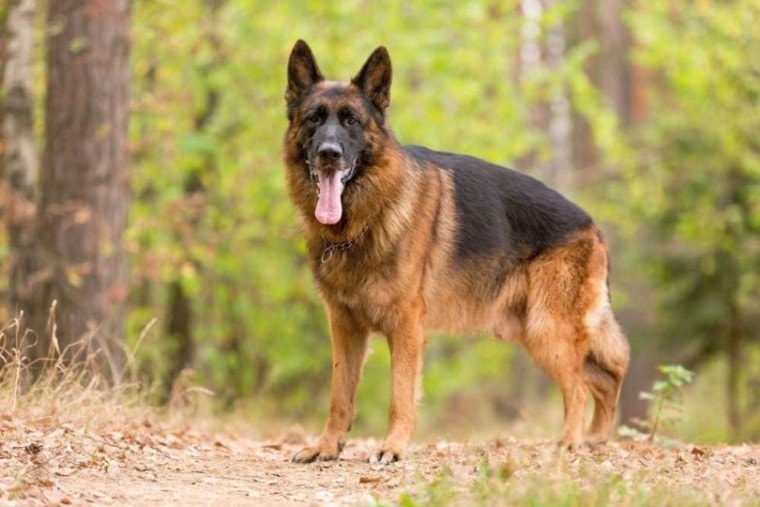

In [100]:
Image.open(io.BytesIO(img_bytes))

In [101]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [102]:
file_list = sagemaker.Session().list_s3_files(bucket=bucket, key_prefix='dog-data-images/test')
class_list = np.unique([file.split('/')[2] for file in file_list])

In [103]:
class_list[response.argmax()]

'071.German_shepherd_dog'

In [104]:
print("Predictions:", response)

Predictions: [[-14.56628895  -9.30092335  -9.85091782  -8.45706081 -16.23241234
  -20.49352264 -11.90534687 -16.04851913 -14.14535904  -8.41470909
   -5.37960911 -17.90376472  -3.81497669  -9.20774078 -10.57413006
  -19.35237503 -23.95485497  -6.06305838 -19.33709908   2.58314657
   -5.03243637   3.85997009 -17.87359619 -31.43946075  -9.70393944
  -13.10716343  -7.48205042 -11.22908306 -12.4150362  -14.09593391
   -8.96359158 -17.99383354  -9.00167751  -7.58041668 -17.08616638
   -7.24270821 -17.90284348  -9.54572392 -13.30340862 -23.78417969
  -11.27532768  -9.76307678  -5.13914108  -6.82455206 -14.54284286
  -22.13713837 -15.45152664 -11.09164143  -9.35205078 -14.58003235
  -16.10847664 -19.11058998 -21.46186829  -8.05228424 -14.05602646
  -12.03898907 -22.66448021 -17.00758171  -5.59570932 -22.05811691
  -14.72771168 -18.27979851 -13.47865009 -13.30057812 -25.665308
  -18.22562408 -15.6124239  -13.23055935  -7.55080509  -7.06939411
    5.0098114  -14.8514576  -13.37287235  -3.758954

In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()